# Analysing Data Scientist Salaries

In this notebook, we will analyze the [Kaggle Jobs Dataset from Glassdoor](https://www.kaggle.com/datasets/thedevastator/jobs-dataset-from-glassdoor) that contains job postings from Glassdoor.com from 2017. We use the `eda_data.csv` from the website that contain some additional features retrieved from the job description.

We aim to analyze the dataset considering the following research questions:

- What are the key factors that affect data science salaries? 
- Can we predict the salary of data science positions based on the job postings?  

### Codebook
Below is a list of the features in the dataset and their explanations. There are 33 features in total. In all of the features, a value `-1` indicates missing values.

1. `job_id`: The unique identifier for the job posting (Numeric).
2. `job_title`: Title of the listed position.
3. `salary_estimate`: A range `[min_salary, max_salary]` for the position listed in Glassdoor.
4. `job_description`: The description of the position.
5. `rating`: A rating for the job `[0, 5]` (Numeric).
6. `company_name`: Employer for the job posting.
7. `location`: Location of work for the position.
8. `headquarters`: Location of the employer's headquarters.
9. `size`: Size estimation of the employer.
10. `founded`: Year the company was founded (Numeric).
11. `type_of_ownership`: Ownership type of the company.
12. `industry`: Industry the position and employer belong to.
13. `sector`: Sector within the industry for the position and employer.
14. `revenue`: Estimated revenue of the employer.
15. `competitors`: The competitors against the employer in the same market.
16. `hourly`: If the salary for the position is paid hourly (True/False, Numeric).
17. `employer_provided`: Whether the salary is provided by the employer in the description (True/False, Numeric).
18. `min_salary`: Minimum salary for the position based on `salary_estimate` (Numeric).
19. `max_salary`: Maximum salary for the position based on `salary_estimate` (Numeric).
20. `avg_salary`: Average salary for the position based on `salary_estimate` (Numeric).
21. `company_txt`: Simplified company name.
22. `job_state`: State where the job is located.
23. `same_state`:  A binary indicator of whether the job is in the same state as the person looking at the job(True/False, Numeric).
24. `age`: The age of the person looking at the job (Numeric).
25. `python_yn`: A binary indicator of whether the person knows Python (Numeric).
26. `r_yn`: A binary indicator of whether the person knows R (Numeric).
27. `spark`: A binary indicator of whether the person knows Spark (Numeric).
28. `aws`: A binary indicator of whether the person knows AWS (Numeric).
29. `excel`: A binary indicator of whether the person knows Excel (Numeric).
30. `job_simp`: A simplified job title.
31. `seniority`: The seniority of the job.
32. `desc_len`: The length of the job description (Numeric).
33. `num_comp`: The number of competitors for the job (Numeric).

## Setup the dataset to HDFS for big data analysis

The HDFS will allow us to store and retrieve the data efficiently for our analysis. It makes sure the data is readily available in parallel.

Before loading the data to HDFS we added the missing header **ID** into files `eda_data.csv` and `glassdoor_jobs.csv`.

In [1]:
# TODO: SET UP COMMANDS

## EDA

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
# plt.rcParams['figure.figsize'] = (5.5,4)
# plt.rcParams['figure.dpi'] = 150


conf = SparkConf().set('spark.ui.port', '4040')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName('Data Scientist Salaries').master('local[*]').getOrCreate()

24/10/26 00:47:41 WARN Utils: Your hostname, MacBook-Pro-Eric.local resolves to a loopback address: 127.0.0.1; using 213.112.21.222 instead (on interface en0)
24/10/26 00:47:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/26 00:47:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
# read the dataset, ecape quotes inside the job descriptions
df = spark.read.csv('./dataset/eda_data.csv', header=True, inferSchema=True, multiLine=True, quote='"', escape='"', mode='PERMISSIVE')
df.show(5)

24/10/26 00:47:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+--------------------+--------------------+--------------------+------+--------------------+---------------+--------------+--------------------+-------+------------------+--------------------+--------------------+--------------------+--------------------+------+-----------------+----------+----------+----------+--------------------+---------+----------+---+---------+----+-----+---+-----+--------------+---------+--------+--------+
| ID|           Job Title|     Salary Estimate|     Job Description|Rating|        Company Name|       Location|  Headquarters|                Size|Founded| Type of ownership|            Industry|              Sector|             Revenue|         Competitors|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|same_state|age|python_yn|R_yn|spark|aws|excel|      job_simp|seniority|desc_len|num_comp|
+---+--------------------+--------------------+--------------------+------+--------------------+---------------+------------

In [5]:
print('Data statistics:')
print(' - Number of datapoints:', df.count())
print(' - Number of columns:', len(df.columns))

Data statistics:


 - Number of datapoints: 742
 - Number of columns: 33


**Show schema:**

In [6]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Job Title: string (nullable = true)
 |-- Salary Estimate: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Company Name: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Headquarters: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Founded: integer (nullable = true)
 |-- Type of ownership: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Revenue: string (nullable = true)
 |-- Competitors: string (nullable = true)
 |-- hourly: integer (nullable = true)
 |-- employer_provided: integer (nullable = true)
 |-- min_salary: integer (nullable = true)
 |-- max_salary: integer (nullable = true)
 |-- avg_salary: double (nullable = true)
 |-- company_txt: string (nullable = true)
 |-- job_state: string (nullable = true)
 |-- same_state: integer (nullable = true)
 |-- age: integer (nullable = 

### Data Cleaning

First, we will fix our dataset with regard to missing values and either fill the instances or drop the records containing these values.

**Handling of irrelevant features:**

The dataset contains a lot of columns that are interesting and could be used for the predicitons.  We have decided to drop features that will not be necessary for our analysis, from the data set, to decrease dimensionality and also the number of missing values that need to be filled. Since the `Job Description` column contains a long string of text we choose to drop and use `desc_len` as an inidicator of how detailed the descriptions for each job are. We also do not care about where a single person wants to work or their feature so we drop columns `same_state` and `age`. `Company Name` is just a raw version of `company_txt`, and `Salary Estimate` is already diveded to `min_salary`, `avg_salary` and `max_salary`.

In [7]:
def drop_irrelevant_cols(df):
    df = df.drop(*['Job Description', 'age', 'same_state', 'Competitors', 'Company Name', 'Salary Estimate'])
    return df

df = drop_irrelevant_cols(df)

In [8]:
cols_missing_values = []
for col in df.columns:
    missing_count = df.filter((F.isnan(F.col(col)) | F.col(col).isNull())).count()
    if missing_count > 0:
        cols_missing_values.append((col, missing_count))

print("Columns with missing values:", cols_missing_values)

Columns with missing values: []


In [9]:
df.describe().show()

+-------+------------------+-----------------+------------------+----------------+-------------------+-------+-----------------+-----------------+---------+----------------+--------------------+-------------------+--------------------+-----------------+------------------+------------------+--------------------+---------+-------------------+--------------------+-------------------+-------------------+-------------------+--------+---------+------------------+------------------+
|summary|                ID|        Job Title|            Rating|        Location|       Headquarters|   Size|          Founded|Type of ownership| Industry|          Sector|             Revenue|             hourly|   employer_provided|       min_salary|        max_salary|        avg_salary|         company_txt|job_state|          python_yn|                R_yn|              spark|                aws|              excel|job_simp|seniority|          desc_len|          num_comp|
+-------+------------------+----------

Based on this the missing values shown as a string `-1`. Let's continue processing.

**Handling missing values:**

The dataset uses value `-1` to indicate missing values on most columns, which is also visible in the dataset description above showing the summaries per column. We will deal with these column by column case, and fill them with actual data accordingly.

In [10]:
cols_missing_values = []
for col in df.columns:
    missing_count = df.filter(F.col(col) == -1).count()
    if missing_count > 0:
        cols_missing_values.append((col, missing_count))

print('Columns with missing values:', cols_missing_values)
print('Total number of missing values:', sum(count for _, count in cols_missing_values))

Columns with missing values: [('Rating', 11), ('Headquarters', 1), ('Size', 1), ('Founded', 50), ('Type of ownership', 1), ('Industry', 10), ('Sector', 10), ('Revenue', 1)]
Total number of missing values: 85


After playing around with the data by checking the following condition for each column above, it seems that one of the records seem to have many missing values, so we drop it. 

In [11]:
bad_record = df.filter(df['Headquarters'] == -1)
bad_record.show()

+---+--------------------+------+-------------+------------+----+-------+-----------------+--------+------+-------+------+-----------------+----------+----------+----------+--------------------+---------+---------+----+-----+---+-----+--------+---------+--------+--------+
| ID|           Job Title|Rating|     Location|Headquarters|Size|Founded|Type of ownership|Industry|Sector|Revenue|hourly|employer_provided|min_salary|max_salary|avg_salary|         company_txt|job_state|python_yn|R_yn|spark|aws|excel|job_simp|seniority|desc_len|num_comp|
+---+--------------------+------+-------------+------------+----+-------+-----------------+--------+------+-------+------+-----------------+----------+----------+----------+--------------------+---------+---------+----+-----+---+-----+--------+---------+--------+--------+
|581|Scientist – Cance...|  -1.0|Cambridge, MA|          -1|  -1|     -1|               -1|      -1|    -1|     -1|     0|                1|       100|       135|     117.5|Monte Ro

Drop the corrputed sample:

In [12]:
df = df.filter(df['ID'] != 581)

Check again after dropping faulty sample:

In [13]:
cols_missing_values = []
for col in df.columns:
    missing_count = df.filter(F.col(col) == -1).count()
    if missing_count > 0:
        cols_missing_values.append((col, missing_count))

print("Columns with missing values:", cols_missing_values)
print('Total number of missing values:', sum(count for _, count in cols_missing_values))

Columns with missing values: [('Rating', 10), ('Founded', 49), ('Industry', 9), ('Sector', 9)]
Total number of missing values: 77


The `Rating`is a value in range $[0, 5]$, `Founded` corresponds to a year, `Industry` and `Sector` are categoricals that already have a variable for value *Unknown*. 

For `Rating` we decided that assuming the mean is reasonable for missing values, and for `Founded` the median (most common year). For `Industry` and `Sector` we can use the already defined *Unknown* value to fill the `-1`s.

In [14]:
# Find the median, max and min of the founded column
min_max_median = df.filter(df['Founded'] != -1).agg(
    F.min('Founded').alias('min_value'),
    F.max('Founded').alias('max_value'),
    F.expr('percentile_approx(Founded, 0.5)').alias('median_value')  # 0.5 for median
)

min_max_median.show()

+---------+---------+------------+
|min_value|max_value|median_value|
+---------+---------+------------+
|     1744|     2019|        1992|
+---------+---------+------------+



With further exploration we found missing values (`-1`or `na`) per column accordingly:

- Rating - 11  -> `3` (mean)
- Industry - `9`
- Sector - 9 -> `Unknown`
- Founded - 49 -> `1992` (median)
- seniority - 519 -> `med` (medium experience)
- job_simp - 183 -> `other` (not a specific datascience role but more vague such as research scientist)


The arrow points out the value to be used as the filler.

In [15]:
def fill_missing_values(df):
    df = df.withColumn('Rating', F.when(df['Rating'] == -1, 3.0).otherwise(df['Rating']))  # use the mean
    df = df.withColumn('Industry', F.when(df['Industry'] == -1, 'Unknown').otherwise(df['Industry']))  # the column already has a label Unknown so we use it
    df = df.withColumn('Founded', F.when(df['Founded'] == -1, 1992).otherwise(df['Founded']))  # fill in median year founded
    df = df.withColumn('Sector', F.when(df['Sector'] == -1, df['Industry']).otherwise(df['Sector']))  # fill in based on indestry, often sector=industry

    # change the na of seniotrity to mean mediocare experience requirements
    df = df.withColumn('seniority', F.when(df['seniority'] == 'na', 'med').otherwise(df['seniority'])) 
    # not a clearly deined job position, research or scientist positons, devops/spark engineers or many tasks etc
    df = df.withColumn('job_simp', F.when(df['job_simp'] == 'na', 'other').otherwise(df['job_simp'])) 
    return df

df = fill_missing_values(df)

In [16]:
df.dtypes

[('ID', 'int'),
 ('Job Title', 'string'),
 ('Rating', 'double'),
 ('Location', 'string'),
 ('Headquarters', 'string'),
 ('Size', 'string'),
 ('Founded', 'int'),
 ('Type of ownership', 'string'),
 ('Industry', 'string'),
 ('Sector', 'string'),
 ('Revenue', 'string'),
 ('hourly', 'int'),
 ('employer_provided', 'int'),
 ('min_salary', 'int'),
 ('max_salary', 'int'),
 ('avg_salary', 'double'),
 ('company_txt', 'string'),
 ('job_state', 'string'),
 ('python_yn', 'int'),
 ('R_yn', 'int'),
 ('spark', 'int'),
 ('aws', 'int'),
 ('excel', 'int'),
 ('job_simp', 'string'),
 ('seniority', 'string'),
 ('desc_len', 'int'),
 ('num_comp', 'int')]

In [17]:
df.describe().show()

+-------+------------------+-----------------+------------------+----------------+-------------------+-----------------+------------------+--------------------+----------+------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+---------+------------------+--------------------+-------------------+-------------------+------------------+--------+---------+------------------+------------------+
|summary|                ID|        Job Title|            Rating|        Location|       Headquarters|             Size|           Founded|   Type of ownership|  Industry|            Sector|             Revenue|              hourly|   employer_provided|        min_salary|        max_salary|        avg_salary|         company_txt|job_state|         python_yn|                R_yn|              spark|                aws|             excel|job_simp|seniority|          desc_len|          num_comp|
+---

All missing values have been handled.

## Visualizations

### General insights from the data

Let's start by getting a general idea of how the dataset looks.

**Raincloud plot over `avg_salary`:**

Statistics on avg salary:
count       741.000000
mean     100603.238866
std       38877.238394
min       13500.000000
25%       73500.000000
50%       97500.000000
75%      122500.000000
max      254000.000000
dtype: float64


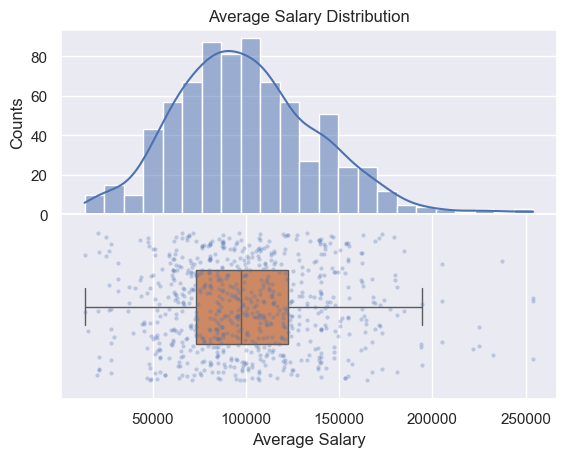

In [18]:
fig, axs = plt.subplots(nrows=2)

avg_salary_data = pd.Series([row['avg_salary'] * 1000 for row in df.select('avg_salary').collect()])
sns.histplot(
    avg_salary_data,
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    avg_salary_data, 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    avg_salary_data,
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(avg_salary_data) * 0.05
xmin = np.min(avg_salary_data) - spacer
xmax = np.max(avg_salary_data) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].set_ylabel('Counts')
axs[0].set_title('Average Salary Distribution')

# Put the two plots together
plt.subplots_adjust(hspace=0)

print(f'Statistics on avg salary:\n{avg_salary_data.describe()}')

# Adjust boxplot fill to be white
plt.xlabel('Average Salary')
plt.show()

Statistics on ratings:
count    741.000000
mean       3.679082
std        0.572035
min        1.900000
25%        3.300000
50%        3.700000
75%        4.000000
max        5.000000
dtype: float64


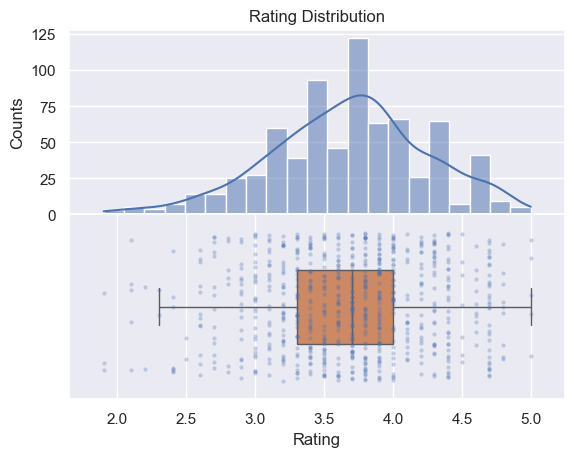

In [19]:
fig, axs = plt.subplots(nrows=2)

rating_data = pd.Series([row['Rating'] for row in df.select('Rating').collect()])
sns.histplot(
    rating_data,
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    rating_data, 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    rating_data,
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(rating_data) * 0.05
xmin = np.min(rating_data) - spacer
xmax = np.max(rating_data) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].set_ylabel('Counts')
axs[0].set_title('Rating Distribution')

# Put the two plots together
plt.subplots_adjust(hspace=0)

print(f'Statistics on ratings:\n{rating_data.describe()}')

# Adjust boxplot fill to be white
plt.xlabel('Rating')
plt.show()

**Job title ferquency:**

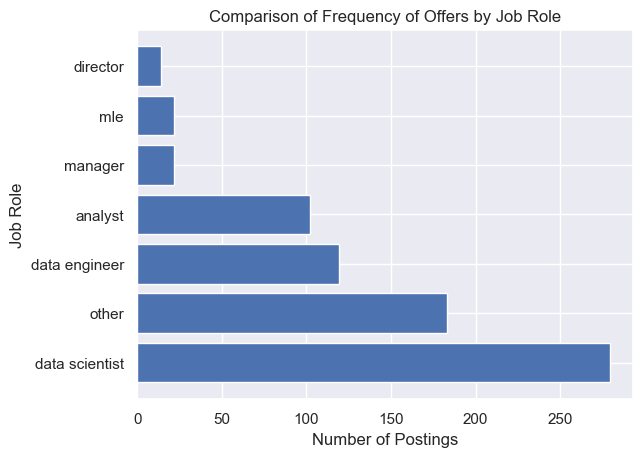

In [20]:
job_freq = df.groupBy('job_simp').count().toPandas()
job_freq = job_freq.sort_values(by='count', ascending=False)
plt.barh(job_freq['job_simp'], job_freq['count'])
plt.title('Comparison of Frequency of Offers by Job Role')
plt.xlabel('Number of Postings')
plt.ylabel('Job Role')
plt.show()

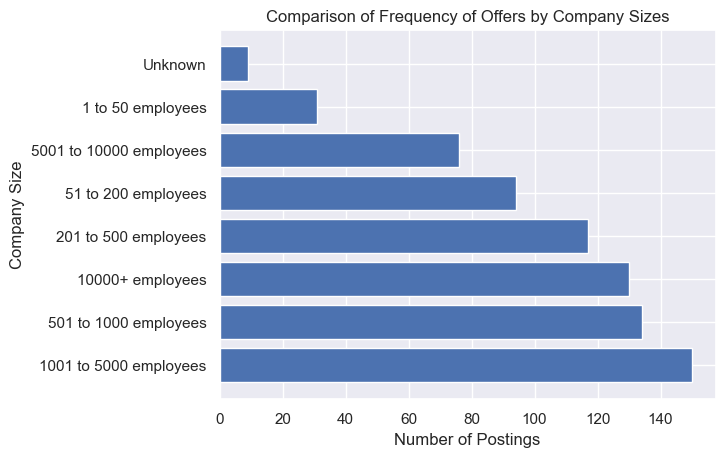

In [21]:
company_sizes = df.groupBy('Size').count().toPandas()
company_sizes = company_sizes.sort_values(by='count', ascending=False)
plt.barh(company_sizes['Size'], company_sizes['count'])
plt.title('Comparison of Frequency of Offers by Company Sizes')
plt.xlabel('Number of Postings')
plt.ylabel('Company Size')
plt.show()

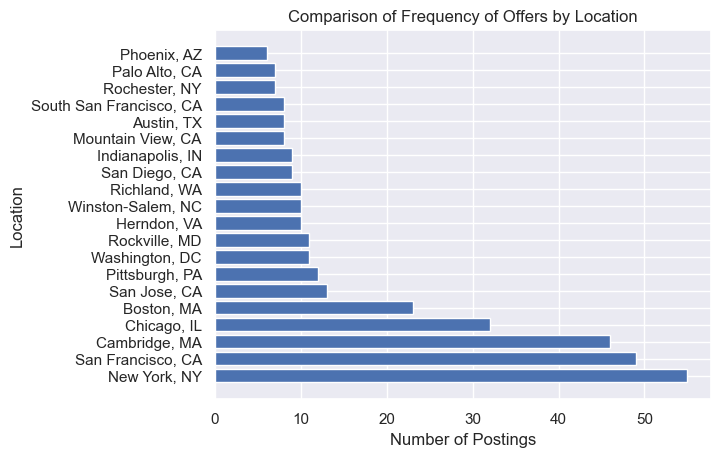

In [22]:
loc_freq = df.groupBy('Location').count().toPandas()
loc_freq = loc_freq.sort_values(by='count', ascending=False)
plt.barh(loc_freq[:20]['Location'], loc_freq[:20]['count'])
plt.title('Comparison of Frequency of Offers by Location')
plt.xlabel('Number of Postings')
plt.ylabel('Location')
plt.show()

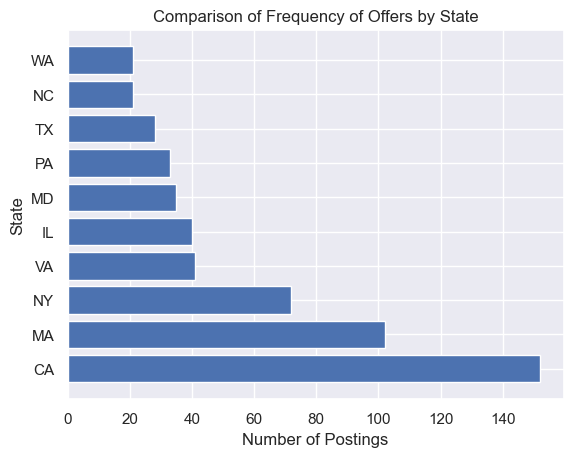

In [23]:
state_freq = df.groupBy('job_state').count().toPandas()
state_freq = state_freq.sort_values(by='count', ascending=False)
plt.barh(state_freq[:10]['job_state'], state_freq[:10]['count'])
plt.title('Comparison of Frequency of Offers by State')
plt.xlabel('Number of Postings')
plt.ylabel('State')
plt.show()

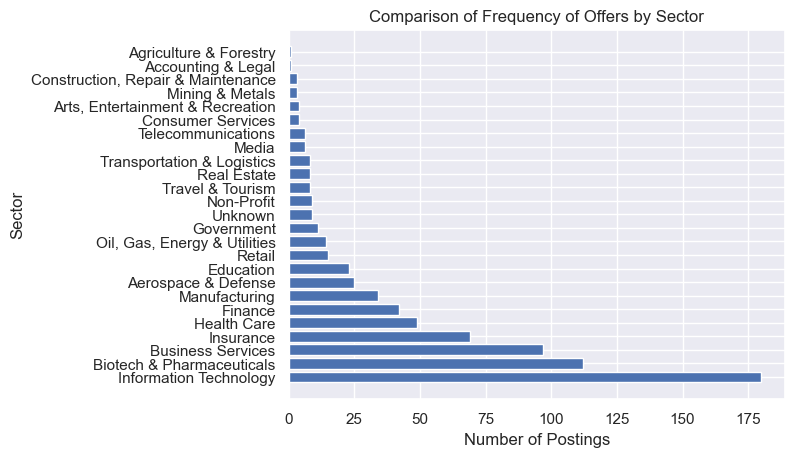

In [24]:
sector_freq = df.groupBy('Sector').count().toPandas()
sector_freq = sector_freq.sort_values(by='count', ascending=False)
plt.barh(sector_freq['Sector'], sector_freq['count'])
plt.title('Comparison of Frequency of Offers by Sector')
plt.xlabel('Number of Postings')
plt.ylabel('Sector')
plt.show()

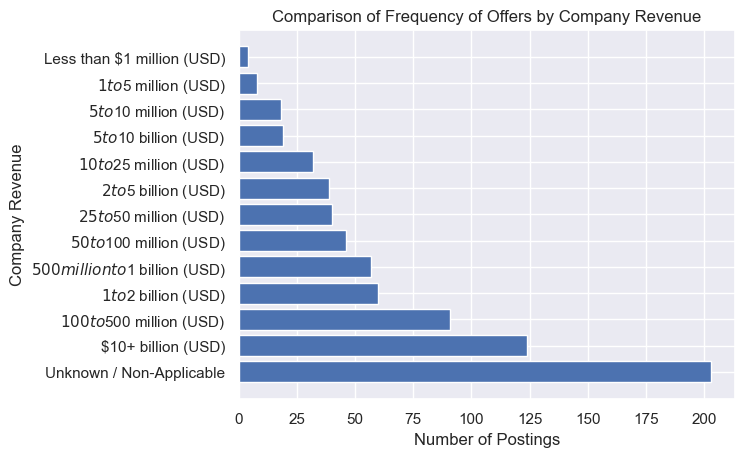

In [25]:
revenue_freq = df.groupBy('Revenue').count().toPandas()
revenue_freq = revenue_freq.sort_values(by='count', ascending=False)
plt.barh(revenue_freq['Revenue'], revenue_freq['count'])
plt.title('Comparison of Frequency of Offers by Company Revenue')
plt.xlabel('Number of Postings')
plt.ylabel('Company Revenue')
plt.show()

#### Observations:

##### Average Salary
From this data, it can be observed that most of the job postings are offering salaries around the **$100,000** mark, indicating some sort of central tendency within this range. However, there are a few key outliers on the high end that would indicate some positions are well over that average, showing many opportunities and possibilities for higher earning potential within certain sectors. This suggests both typical earning potential and lucrative jobs within the market.

##### Job Ratings
The job ratings data indicates that most jobs are rated around **3.5**, with the interquartile range between 3.0 and 4.0. This suggests that while most jobs have a moderate level of satisfaction, there is also a fair spread of ratings, indicating varied job quality and experiences. The peak in the histogram further emphasizes this central tendency.

##### Frequency of Offers
The heavily skewed distribution of frequency of offers shows an exploding need for data scientist at workplaces right now. Manager, director and machine learning engineer postings are way less common, supposedly because those are either more specialized or high-level positions.

Besides that, larger companies have more job postings, which also lies in-line with the expectation that lagrer companies can give jobs to more people.

By location, **New York**, **San Francisco**, **Cambridge**, **Chicago** and **Boston** lead the pack with a huge amount of job postings each. This can be further connected with the most desirable job title and sector: **data scientist** and **Information Technology**. There should be a big cluster of high-tech companies at these locations.


### Feature selection and modeling

Start by splittin the data with $80\% - 20\%$ train-test split. Since we are interested in salaries, the plots will be comparisons against salaries.

In [26]:
seed = 42

train_df, test_df = df.randomSplit(weights=[0.8,0.2], seed=seed)
print('Train size:', train_df.count(), '-- Test size:', test_df.count())

Train size: 622 -- Test size: 119


**Check correlations between numerical data:**

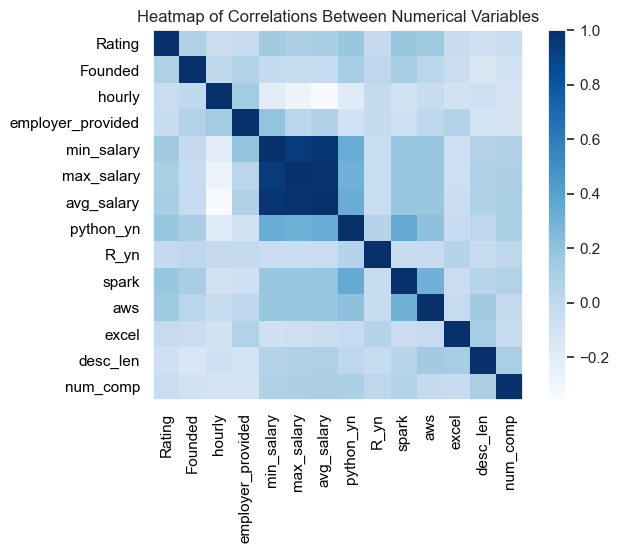

In [27]:
# see how the different (numerical) variables correlate with Avg Salary
num_train_df = df.select(['Rating', 'Founded', 'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
                          'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'desc_len', 'num_comp'])
num_train_data_pd = num_train_df.toPandas()
correlation = num_train_data_pd.corr()

plt.imshow(correlation, cmap=plt.cm.Blues)
plt.yticks(np.arange(0, len(correlation.index), 1), correlation.index, color='black')
plt.xticks(np.arange(0, len(correlation.columns), 1), correlation.columns, rotation=90, color='black')
plt.colorbar()
plt.grid(False)
plt.title('Heatmap of Correlations Between Numerical Variables')
plt.show()

This heatmap gives an idea of how most of the variables are strongly positively related to each other. For example, ```min_salary```, ```max_salary```, and ```avg_salary``` show strong positive relation, meaning that as minimum and maximum salaries increase, the average tends to get higher *(as expected)*. ```Python_yn``` is moderately positively related with ```avg_salary```; hence, jobs requiring Python skills are likely to have a higher average salary. On the other hand, variables ```num_comp``` and ```Rating``` are weakly negatively correlated, which might indicate that companies with higher competition receive slightly worse ratings. These insights show that the most important factors in determining job compensation relate to salary metrics and Python skills, and hint at the competitive landscape's impact on company ratings.

**Avg Salary vs Ratings:**

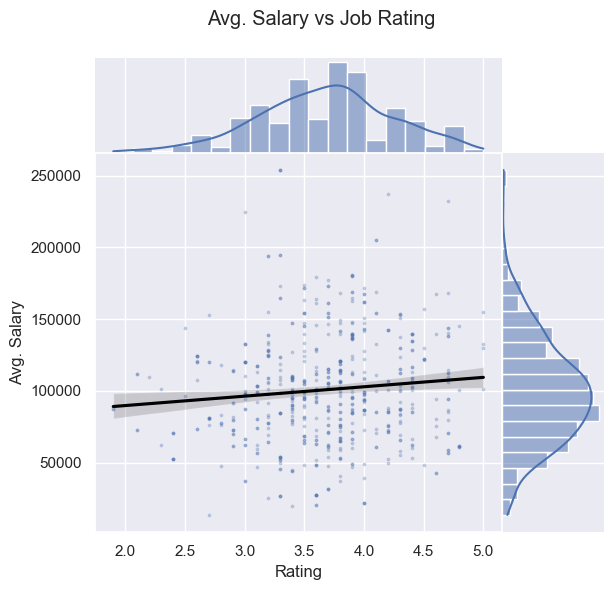

In [28]:
avg_salary_data = pd.Series([row['avg_salary'] * 1000 for row in train_df.select('avg_salary').collect()])
rating_data = pd.Series([row['Rating'] for row in train_df.select('Rating').collect()])
sns.jointplot(
    x=rating_data, 
    y=avg_salary_data, 
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)
plt.xlabel('Rating')
plt.ylabel('Avg. Salary')
plt.suptitle('Avg. Salary vs Job Rating')
plt.subplots_adjust(top=0.9)
plt.show()

**Avg Salary vs Company Founded:**

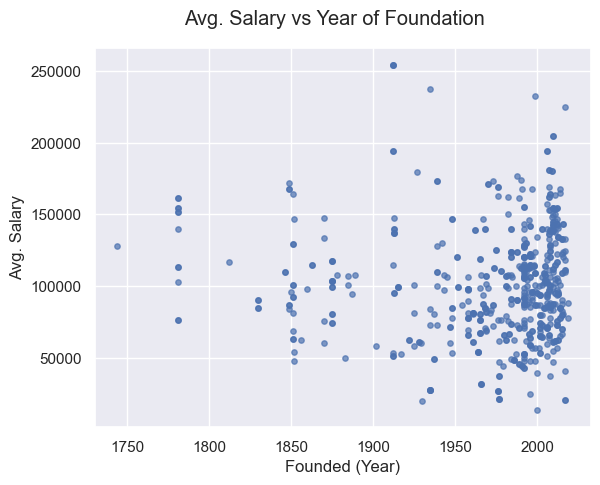

In [29]:
founded_data = pd.Series([row['Founded'] for row in train_df.select('Founded').collect()])
plt.scatter(founded_data, avg_salary_data, s=15, alpha=0.7)
plt.xlabel('Founded (Year)')
plt.ylabel('Avg. Salary')
plt.suptitle('Avg. Salary vs Year of Foundation')
plt.subplots_adjust(top=0.9)
plt.show()

In [30]:
train_df.groupBy('employer_provided').count().show()

+-----------------+-----+
|employer_provided|count|
+-----------------+-----+
|                1|   14|
|                0|  608|
+-----------------+-----+



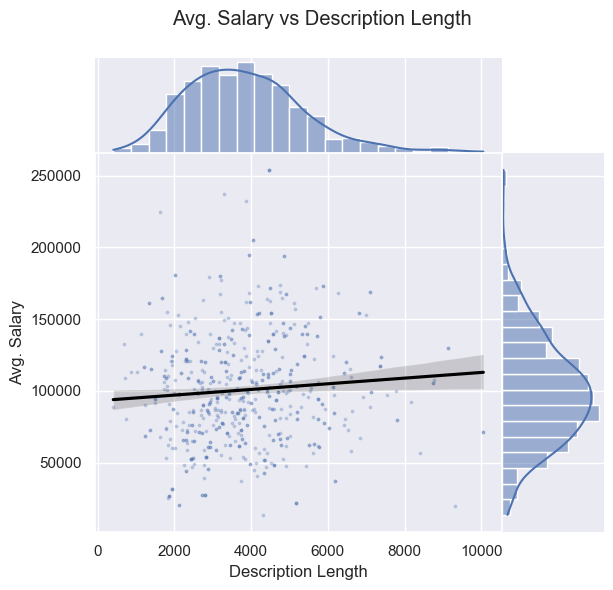

In [31]:
desc_data = pd.Series([row['desc_len'] for row in train_df.select('desc_len').collect()])
sns.jointplot(
    x=desc_data, 
    y=avg_salary_data, 
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)
plt.xlabel('Description Length')
plt.ylabel('Avg. Salary')
plt.suptitle('Avg. Salary vs Description Length')
plt.subplots_adjust(top=0.9)
plt.show()

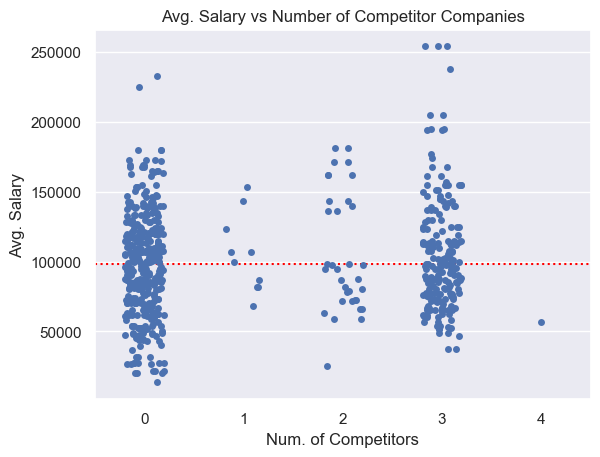

In [32]:
competitor_data = pd.Series([row['num_comp'] for row in train_df.select('num_comp').collect()])

fig, ax = plt.subplots()
sns.stripplot(x=competitor_data, y=avg_salary_data, jitter=0.2, ax=ax)
ax.axhline(y=avg_salary_data.median(), color='red', linestyle='dotted')
plt.title('Avg. Salary vs Number of Competitor Companies')
plt.ylabel('Avg. Salary')
plt.xlabel('Num. of Competitors')
plt.show()

### Categorical data

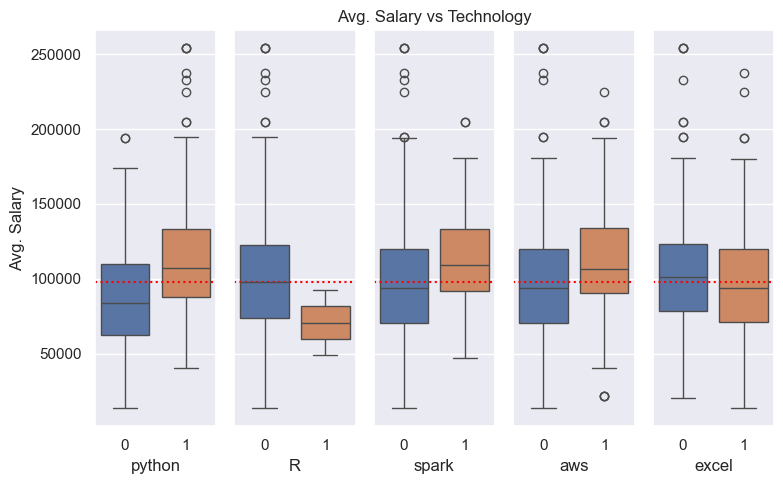

In [33]:
technologies = [pd.Series([row[tech] for row in train_df.select(tech).collect()]) for tech in ['python_yn', 'R_yn', 'spark', 'aws', 'excel']]


fig, axes = plt.subplots(1, 5, figsize=(8, 5), sharey=True)

i = 0
techs = ['python', 'R', 'spark', 'aws', 'excel']
for ax, tech in zip(axes.flatten(), technologies):
    sns.boxplot(x=tech, y=avg_salary_data, ax=ax, hue=tech, legend=False)
    ax.set_ylabel('Avg. Salary')
    ax.set_xlabel(techs[i])
    ax.axhline(y=avg_salary_data.median(), 
               color='red',
               linestyle='dotted'
            )
    i += 1

    if i == 3:
        ax.set_title('Avg. Salary vs Technology')

plt.tight_layout()
plt.show()

/var/folders/b7/qpmny0bj4f7cpkfwlv003pcw0000gn/T/ipykernel_83238/2199496477.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)


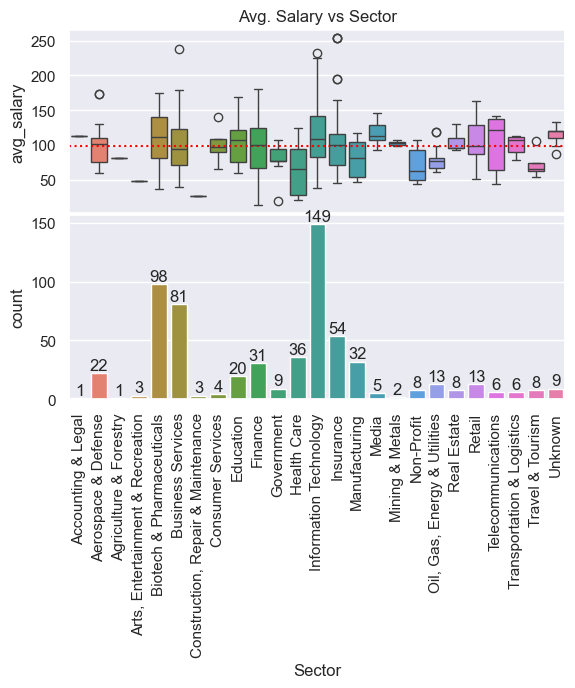

In [34]:
fig, axs = plt.subplots(nrows=2)

plot_data = train_df.select(['Sector', 'avg_salary']).toPandas()
sns.boxplot(
    x='Sector',
    y='avg_salary',
    data=plot_data.sort_values('Sector'),
    ax=axs[0], 
    hue='Sector', 
    legend=False
)

sns.countplot(
    x='Sector',
    data=plot_data.sort_values('Sector'),
    ax=axs[1], 
    hue='Sector', 
    legend=False
)

# Draw median price
axs[0].axhline(
    y=plot_data['avg_salary'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)
axs[0].set_title('Avg. Salary vs Sector')
plt.show()

In [35]:
# Count distinct values in a column (replace 'column_name' with your column)
distinct_count = df.select('Industry').distinct().count()

print(f"Distinct count in column 'column_name': {distinct_count}")


Distinct count in column 'column_name': 60


## Predictions

In [36]:
train_df.columns  # sector, ownership, python excel spark R, job_simp, seniority, state, location?, revenue

['ID',
 'Job Title',
 'Rating',
 'Location',
 'Headquarters',
 'Size',
 'Founded',
 'Type of ownership',
 'Industry',
 'Sector',
 'Revenue',
 'hourly',
 'employer_provided',
 'min_salary',
 'max_salary',
 'avg_salary',
 'company_txt',
 'job_state',
 'python_yn',
 'R_yn',
 'spark',
 'aws',
 'excel',
 'job_simp',
 'seniority',
 'desc_len',
 'num_comp']